In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ppi = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ppi_human.txt', sep = '\t')
print(len(ppi))
ppi.head()

315934


,Protein_A_idx,Protein_B_idx,Interaction,Uniprot_A,Uniprot_B
0,11777,537,0.045,Q9HCE7,Q9BYM8
1,11777,5865,0.508,Q9HCE7,P51668
2,11777,10925,0.080,Q9HCE7,P17844
3,11777,6695,0.156,Q9HCE7,P38646
4,11777,4966,0.264,Q9HCE7,Q9H469


In [ ]:
ppi['Interaction'] = (ppi['Interaction'] > 0).astype(int)
ppi.head()

,Protein_A_idx,Protein_B_idx,Interaction,Uniprot_A,Uniprot_B
0,11777,537,1,Q9HCE7,Q9BYM8
1,11777,5865,1,Q9HCE7,P51668
2,11777,10925,1,Q9HCE7,P17844
3,11777,6695,1,Q9HCE7,P38646
4,11777,4966,1,Q9HCE7,Q9H469


In [ ]:
num_of_protein_A = len(ppi['Protein_A_idx'].unique())
num_of_protein_B = len(ppi['Protein_B_idx'].unique())

In [ ]:
def compile_model(num_of_user, num_of_item, learning_rate = 0.001):
  VECTOR_DIMENSION = 8

  protein_A_input = keras.layers.Input((1,))
  protein_A_embedding = keras.layers.Embedding(num_of_protein_A, VECTOR_DIMENSION, input_length = 1, name = 'protein_A_embedding')
  protein_A = protein_A_embedding(protein_A_input)
  protein_A = keras.layers.Reshape((VECTOR_DIMENSION, 1))(protein_A)

  protein_B_input = keras.layers.Input((1,))
  protein_B_embedding = keras.layers.Embedding(num_of_protein_B, VECTOR_DIMENSION, input_length = 1, name = 'protein_B_embedding')
  protein_B = protein_B_embedding(protein_B_input)
  protein_B = keras.layers.Reshape((VECTOR_DIMENSION, 1))(protein_B)

  dot_product = keras.layers.dot([protein_A, protein_B], axes = 1)
  output = keras.layers.Activation('sigmoid')(dot_product)

  model = keras.models.Model(inputs=[protein_A_input, protein_B_input], outputs = output)
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = keras.optimizers.Adam(learning_rate = learning_rate),
      metrics = ['binary_accuracy'],
  )
  return model

model = compile_model(num_of_protein_A, num_of_protein_B)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 protein_A_embedding (Embedding  (None, 1, 8)        115232      ['input_19[0][0]']               
 )                                                                                                
                                                                                                  
 protein_B_embedding (Embedding  (None, 1, 8)        115120      ['input_20[0][0]']         

In [ ]:
pa2idx = {v: k for k, v in dict(enumerate(ppi['Protein_A_idx'].unique())).items()}
pb2idx = {v: k for k, v in dict(enumerate(ppi['Protein_B_idx'].unique())).items()}

dataset = pd.DataFrame()
dataset['paidx'] = ppi['Protein_A_idx'].map(pa2idx.get)
dataset['pbidx'] = ppi['Protein_B_idx'].map(pb2idx.get)
dataset['y'] = ppi['Interaction']
dataset

,paidx,pbidx,y
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
315929,5409,6185,0
315930,9149,10338,0
315931,472,13901,0
315932,11791,4912,0


In [ ]:
data_x = np.array([
                   dataset['paidx'].values, 
                   dataset['pbidx'].values
]).T
data_y = np.array([
                   dataset['y'].values
]).T
print(data_x.shape, data_y.shape)
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size = 0.1)
valid_x, test_x, valid_y, test_y = train_test_split(valid_x, valid_y, test_size = 0.5)
print(
    train_x.shape, train_y.shape, 
    valid_x.shape, valid_y.shape,
    test_x.shape, test_y.shape
)

(315934, 2) (315934, 1)
(284340, 2) (284340, 1) (15797, 2) (15797, 1) (15797, 2) (15797, 1)


In [ ]:
model = compile_model(num_of_protein_A, num_of_protein_B)
history = model.fit(
    x = (train_x[:,0,None], train_x[:,1,None]),
    y = train_y, 
    batch_size = 512, 
    epochs = 20, 
    verbose = 'auto', 
    validation_data = ((valid_x[:,0,None], valid_x[:,1,None]),valid_y),
    shuffle = True, 
)

Epoch 1/20
  3/556 [..............................] - ETA: 19s - loss: 0.6931 - binary_accuracy: 0.5293

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


556/556 [==============================] - 23s 41ms/step - loss: 0.6930 - binary_accuracy: 0.5232 - val_loss: 0.6920 - val_binary_accuracy: 0.5937
Epoch 2/20
556/556 [==============================] - 20s 36ms/step - loss: 0.6766 - binary_accuracy: 0.7853 - val_loss: 0.6533 - val_binary_accuracy: 0.7111
Epoch 3/20
556/556 [==============================] - 30s 55ms/step - loss: 0.6071 - binary_accuracy: 0.8465 - val_loss: 0.5792 - val_binary_accuracy: 0.7451
Epoch 4/20
556/556 [==============================] - 24s 43ms/step - loss: 0.5307 - binary_accuracy: 0.8579 - val_loss: 0.5249 - val_binary_accuracy: 0.7579
Epoch 5/20
556/556 [==============================] - 19s 35ms/step - loss: 0.4746 - binary_accuracy: 0.8626 - val_loss: 0.4901 - val_binary_accuracy: 0.7663
Epoch 6/20
556/556 [==============================] - 22s 40ms/step - loss: 0.4331 - binary_accuracy: 0.8676 - val_loss: 0.4667 - val_binary_accuracy: 0.7769
Epoch 7/20
556/556 [==============================] - 23s 42ms/

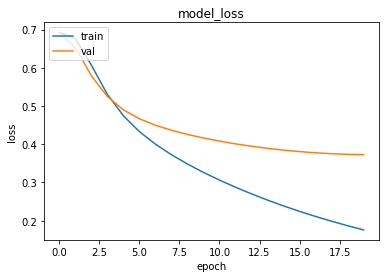

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc = 'upper left')
plt.show()

In [ ]:
model.evaluate(
    x = (test_x[:,0,None], test_x[:,1,None]),
    y = test_y
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


494/494 [==============================] - 11s 23ms/step - loss: 0.3684 - binary_accuracy: 0.8337


[0.36842843890190125, 0.8337026238441467]